In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


KeyboardInterrupt



In [4]:
protein = "WFS1" # GJB2
filename = f'C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\gene_specific_df\\{protein}_with_position.csv'
data = pd.read_csv(f"{filename}")
dot_index = filename.index('_')
gene = filename[:dot_index]
if gene == "combined" or gene == "combined_with_source":
    gene = "7 genes"
if gene == "features":
    gene = "190 genes"

data

,gene,variant,pathogenicity,uniprot_id,stability_WT,stability_MUT,blosum,hydrophobicity_WT,hydrophobicity_MUT,volume_WT,...,oda_MUT,sasa_WT,sasa_MUT,RSA_WT,RSA_MUT,oda_delta,sasa_delta,pssm,entropy,position
0,WFS1,T5A,benign,O76024,406.243,406.410,0,-0.7,1.8,116.1,...,-0.65,144.59,110.51,0.887055,0.913306,-1.27,-34.08,3.675,3.042,5
1,WFS1,P7A,benign,O76024,406.550,406.820,-1,-1.6,1.8,112.7,...,-3.77,129.82,103.89,0.842987,0.858595,0.79,-25.93,4.586,2.483,7
2,WFS1,P7Q,benign,O76024,406.550,406.421,-1,-1.6,-3.5,112.7,...,-0.57,129.82,171.78,0.842987,0.802710,3.99,41.96,4.586,2.483,7
3,WFS1,P16L,benign,O76024,405.800,406.781,-3,-1.6,3.8,112.7,...,-8.98,118.89,163.92,0.772013,0.858220,0.81,45.03,4.641,2.163,16
4,WFS1,P17L,benign,O76024,405.187,405.847,-3,-1.6,3.8,112.7,...,-7.48,127.58,131.68,0.828442,0.689424,-1.29,4.10,3.746,2.255,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,WFS1,Q14R,benign,NaN,405.740,405.538,1,-3.5,-4.5,143.8,...,-10.21,170.60,184.05,0.797196,0.694528,-0.23,13.45,5.242,2.839,14
306,WFS1,L499F,benign,NaN,406.155,405.569,0,3.8,2.8,166.7,...,-114.10,44.63,53.58,0.233665,0.235000,-4.40,8.95,4.098,0.870,499
307,WFS1,D866N,benign,NaN,403.125,405.666,1,-3.5,-3.5,111.1,...,-92.65,101.80,94.71,0.544385,0.506471,-13.02,-7.09,6.115,1.105,866
308,WFS1,G76V,benign,NaN,406.550,406.536,-3,-0.4,4.2,60.1,...,-1.63,73.47,133.73,0.757423,0.810485,-1.64,60.26,3.942,2.494,76


In [5]:
data = pd.get_dummies(data, columns=["secondary_structure"])

mapping = {"benign": 0, "pathogenic": 1}
data["pathogenicity"] = data["pathogenicity"].map(mapping)

data = data.drop(
    labels=["uniprot_id", "stability_WT", "stability_MUT", "hydrophobicity_WT", "hydrophobicity_MUT", "volume_WT",
            "volume_MUT", "sequence_length", "oda_MUT", "oda_WT", "sasa_WT", "sasa_MUT", "RSA_MUT", "variant", "gene",
            "protein_contain_transmembrane", "is_residue_transmembranal", "aa_WT", "aa_MUT"], axis=1, inplace=False)

data

,pathogenicity,blosum,plddt_residue,stability_delta,hydrophobicity_delta,volume_delta,RSA_WT,oda_delta,sasa_delta,pssm,entropy,position,secondary_structure_Loop
0,0,0,36.76,0.167,2.5,-27.5,0.887055,-1.27,-34.08,3.675,3.042,5,True
1,0,-1,37.60,0.270,3.4,-24.1,0.842987,0.79,-25.93,4.586,2.483,7,True
2,0,-1,37.60,-0.129,-1.9,31.1,0.842987,3.99,41.96,4.586,2.483,7,True
3,0,-3,33.77,0.981,5.4,54.0,0.772013,0.81,45.03,4.641,2.163,16,True
4,0,-3,34.09,0.660,5.4,54.0,0.828442,-1.29,4.10,3.746,2.255,17,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0,1,33.40,-0.202,-1.0,29.6,0.797196,-0.23,13.45,5.242,2.839,14,True
306,0,0,82.30,-0.586,-1.0,23.2,0.233665,-4.40,8.95,4.098,0.870,499,True
307,0,1,66.68,2.541,0.0,3.0,0.544385,-13.02,-7.09,6.115,1.105,866,True
308,0,-3,25.97,-0.014,4.6,79.9,0.757423,-1.64,60.26,3.942,2.494,76,True


In [16]:
# structural_features = ["oda_delta", "stability_delta", "secondary_structure_Beta strand", "secondary_structure_Helix", "secondary_structure_Loop", "sasa_delta", "RSA_WT"]
# # Drop structural features
# data = data.drop(labels=["stability_delta"], axis=1, inplace=False)

In [7]:

# Create list of all positions.
positions = data["position"].unique()
probabilities = []
predictions = []
y_tests = []
tps = []
fps = []
fns = []
tns = []
errors = []
mistakes = 0

counter = 0

for pos in positions:
    counter += 1
    print(f"Position: {pos} ({counter}/{len(positions)})")
    # Create train and test sets.
    train = data[data["position"] != pos]
    test = data[data["position"] == pos]

    X_test = test.drop(labels=["pathogenicity", "position"], axis=1, inplace=False)
    y_test = test["pathogenicity"]

    X_train = train.drop(labels=["pathogenicity", "position"], axis=1, inplace=False)
    y_train = train["pathogenicity"]
    
    # Oversample the train set using SMOTE.
    oversample = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)
    # class_distribution = y_train_resampled.value_counts()
    # print(f"Training set: (SMOTE)\n{class_distribution}")

    # Initialize and fit XGBoost model.
    xgb_classifier = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)
    xgb_classifier.fit(X_train_resampled, y_train_resampled)  # Fit the model with the resampled data
    
    # Predict probabilities (Instead of predicting binary values)
    prob = xgb_classifier.predict_proba(X_test)[:, 1]
    y_pred = xgb_classifier.predict(X_test)

    # Store probabilities, predictions, and ground truth labels
    probabilities.extend(prob)
    predictions.extend(y_pred)
    y_tests.extend(y_test)
    
    # Evaluate the model performance.
    tp = sum((y_test == 1) & (y_pred == 1))
    fp = sum((y_test == 0) & (y_pred == 1))
    fn = sum((y_test == 1) & (y_pred == 0))
    tn = sum((y_test == 0) & (y_pred == 0))

    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)

    print(f"tps: {sum(tps)}, fps: {sum(fps)}, fns: {sum(fns)}, tns: {sum(tns)}")

    print(f"Prediction: {y_pred}. Reality: {y_test.values}")

# Calculate MCC
TP = sum(tps)
FP = sum(fps)
FN = sum(fns)
TN = sum(tns)
mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

print(f"TP: {sum(tps)}, FP: {sum(fps)}, TN: {sum(fns)}, FN: {sum(tns)}")

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Results for {gene}:")
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"MCC for {gene}: {mcc}")
print(f"Accuracy: {accuracy}")

Position: 5 (1/245)
TP: 0, FP: 0, TN: 1, FN: 0
tps: 0, fps: 0, fns: 0, tns: 1
Prediction: [0]. Reality: [0]
Position: 7 (2/245)
TP: 0, FP: 0, TN: 2, FN: 0
tps: 0, fps: 0, fns: 0, tns: 3
Prediction: [0 0]. Reality: [0 0]
Position: 16 (3/245)
TP: 0, FP: 0, TN: 1, FN: 0
tps: 0, fps: 0, fns: 0, tns: 4
Prediction: [0]. Reality: [0]
Position: 17 (4/245)
TP: 0, FP: 0, TN: 2, FN: 0
tps: 0, fps: 0, fns: 0, tns: 6
Prediction: [0 0]. Reality: [0 0]
Position: 19 (5/245)
TP: 0, FP: 0, TN: 1, FN: 0
tps: 0, fps: 0, fns: 0, tns: 7
Prediction: [0]. Reality: [0]
Position: 23 (6/245)
TP: 0, FP: 0, TN: 1, FN: 0
tps: 0, fps: 0, fns: 0, tns: 8
Prediction: [0]. Reality: [0]
Position: 40 (7/245)
TP: 0, FP: 0, TN: 1, FN: 0
tps: 0, fps: 0, fns: 0, tns: 9
Prediction: [0]. Reality: [0]
Position: 41 (8/245)
TP: 0, FP: 0, TN: 1, FN: 0
tps: 0, fps: 0, fns: 0, tns: 10
Prediction: [0]. Reality: [0]
Position: 44 (9/245)
TP: 0, FP: 0, TN: 2, FN: 0
tps: 0, fps: 0, fns: 0, tns: 12
Prediction: [0 0]. Reality: [0 0]
Positio

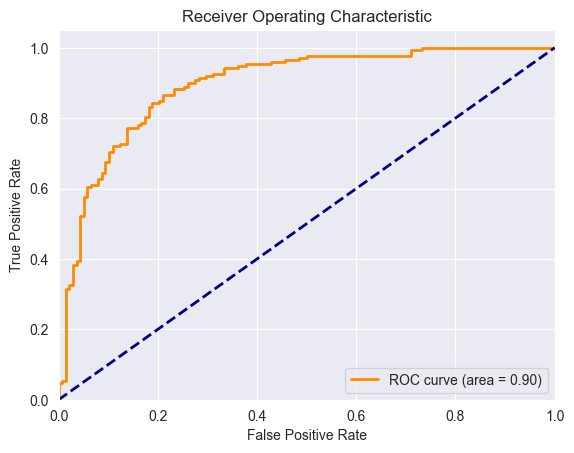

MCC: 0.6479305771393148


In [9]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_tests, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

# create a graph showing the precision for each threshold



In [18]:
####### Getting metrics for current protein and adding to metrics_gene_specific_predictors #######

# metrics = pd.DataFrame(columns=["gene", "sensitivity", "specificity", "precision", "accuracy", "mcc", "num_variants", "num_benign", "num_pathogenic"])
# metrics.to_csv("C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\predictions_vs_real\\gene_specific_predictors\\metrics.csv", index=False)

metrics = pd.read_csv("C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\predictions_vs_real\\gene_specific_predictors\\metrics_gene_specific_predictors.csv")

protein_metrics = pd.DataFrame({
    "gene": [protein],
    "sensitivity": [sensitivity],
    "specificity": [specificity],
    "precision": [precision],
    "accuracy": [accuracy],
    "mcc": [mcc]
})
protein_metrics["num_variants"] = len(data)
protein_metrics["num_benign"] = sum(data["pathogenicity"] == 0)
protein_metrics["num_pathogenic"] = sum(data["pathogenicity"] == 1)
# add TP, FP, FN, TN to the dataframe
protein_metrics["TP"] = TP
protein_metrics["FP"] = FP
protein_metrics["FN"] = FN
protein_metrics["TN"] = TN
metrics = pd.concat([metrics, protein_metrics], ignore_index=True)
# add the number of variants for each protein
metrics.to_csv("C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\predictions_vs_real\\gene_specific_predictors\\metrics_gene_specific_predictors.csv", index=False)
